## Dependencies
This section imports all necessary Python libraries for the project

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import random
warnings.filterwarnings("ignore")

## Performance coefficients
This section defines various metrics for evaluating the model's performance:
- accuracy_coef: Calculates accuracy based on True Positives, True Negatives, False Positives, and False Negatives
- dice_coef: Computes Dice coefficient (F1 score) to measure overlap between predicted and ground truth masks
- dice_loss: Calculates loss based on Dice coefficient
- iou_coef: Computes Intersection over Union (IoU) to measure segmentation accuracy
- bce_dice_loss: Combines Binary Cross Entropy and Dice loss for better training, addresses both pixel-level accuracy and overall segmentation quality

In [14]:
def accuracy_coef(pred, groundtruth, smooth=1e-5):
    """Calculate accuracy based on TP, TN, FP, FN"""
    pred = (pred > 0.5).float()
    groundtruth = (groundtruth > 0.5).float()
    
    # Calculate TP, TN, FP, FN
    TP = torch.sum(pred * groundtruth)
    TN = torch.sum((1 - pred) * (1 - groundtruth))
    FP = torch.sum(pred * (1 - groundtruth))
    FN = torch.sum((1 - pred) * groundtruth)
    
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN + smooth)
    return accuracy

def dice_coef(pred, groundtruth, smooth=1e-5):
    """Calculate Dice coefficient between predicted and groundtruth masks"""
    intersection = torch.sum(pred * groundtruth)
    union = torch.sum(pred) + torch.sum(groundtruth)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(pred, groundtruth):
    """Calculate Dice loss"""
    return 1 - dice_coef(pred, groundtruth)

def iou_coef(pred, groundtruth, smooth=1e-5):
    """Calculate IoU (Intersection over Union) coefficient"""
    intersection = torch.sum(pred * groundtruth)
    union = torch.sum(pred) + torch.sum(groundtruth) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def bce_dice_loss(pred, groundtruth, alpha=0.5):
    """Combined BCE and Dice loss"""
    bce = nn.BCELoss()(pred, groundtruth)
    dice = dice_loss(pred, groundtruth)
    return alpha * bce + (1 - alpha) * dice

## Parameters
This section defines global configuration parameters for the model training:
- Test/validation split ratios for data partitioning
- Random seed for reproducibility
- Image size for input preprocessing
- Batch size for training optimization
- Learning rate and weight decay for optimizer
- Number of training epochs
- Device configuration for GPU/CPU usage

In [15]:
# Global configuration parameters
TEST_SPLIT = 0.2          # Validation split ratio
VAL_SPLIT = 0.875         # 10/80 after test split
RANDOM_SEED = 42          # Random seed for reproducibility
IMAGE_SIZE = 256          # Input image size
BATCH_SIZE = 16           # Batch size for training
LEARNING_RATE = 0.001     # Initial learning rate
WEIGHT_DECAY = 1e-6       # Weight decay for regularization
NUM_EPOCHS = 60           # Number of training epochs

# Set device (GPU/CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Loading and Dataset Class:
This section implements data preparation functionality:
- Defines a load_segmentation_data function that reads and preprocesses image and mask pairs
- Converts images to tensors and resizes them to specified dimensions
- Handles file pair matching between images and their corresponding masks
- Uses torchvision transforms for basic image preprocessing
- Returns stacked tensors of images, masks, and their class labels

In [16]:
def load_segmentation_data(img_paths, mask_paths, shape=256):
    """Load and preprocess image and mask data"""
    images = []
    masks = []
    classes = []
    
    file_pairs_arr = []
    # Get image names
    for img_path in img_paths:
        img_names = os.listdir(img_path)
        base_names = list(set(name.split(')')[0] for name in img_names))
        file_pairs = [(f"{base}).png", f"{base})_mask.png") for base in base_names]
        file_pairs_arr.append(file_pairs)
    
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((shape, shape)),
        transforms.ToTensor()
    ])
    
    for i,file_pairs in enumerate(file_pairs_arr):
        for img_name, mask_name in file_pairs:
            img = Image.open(os.path.join(img_paths[i], img_name)).convert('L')
            mask = Image.open(os.path.join(mask_paths[i], mask_name)).convert('L')
            
            img_tensor = transform(img)
            mask_tensor = transform(mask)
            
            images.append(img_tensor)
            masks.append(mask_tensor)
            classes.append(torch.tensor(i))

    return torch.stack(images), torch.stack(masks), torch.stack(classes)

## Augmentations
This section defines data augmentation strategies:
- Implements AugmentedDataset class inheriting from torch.utils.data.Dataset
- Applies various augmentation techniques including:
  - Random horizontal and vertical flips
  - Random rotations and affine transformations
  - Color jitter (brightness and contrast adjustments)
- Ensures consistent transformations between images and their masks
- Implements get_data_loaders function to create train/val/test data loaders with stratification

In [17]:
class AugmentedDataset(Dataset):
    """Custom dataset with torchvision augmentations for breast cancer segmentation"""
    def __init__(self, images, masks, train=True):
        self.images = images
        self.masks = masks
        self.train = train
        
        # Basic normalization and conversion
        self.normalize = transforms.Normalize(mean=[0.485], std=[0.229])
        
        # Training augmentations
        self.train_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomAffine(
                degrees=30,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1),
                fill=0
            ),
            transforms.ColorJitter(
                brightness=0.2,
                contrast=0.2
            )
        ])

    def __len__(self):
        return len(self.images)
    
    def apply_transforms_to_both(self, image, mask):
        """Apply same spatial transforms to both image and mask"""
        # Convert to PIL Image for transforms
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image)
        if isinstance(mask, torch.Tensor):
            mask = transforms.ToPILImage()(mask)
            
        # Generate random values for transforms
        if random.random() < 0.5:
            image = transforms.functional.hflip(image)
            mask = transforms.functional.hflip(mask)
            
        if random.random() < 0.5:
            image = transforms.functional.vflip(image)
            mask = transforms.functional.vflip(mask)
            
        if random.random() < 0.5:
            angle = random.uniform(-30, 30)
            image = transforms.functional.rotate(image, angle, fill=0)
            mask = transforms.functional.rotate(mask, angle, fill=0)
            
        if random.random() < 0.5:
            scale = random.uniform(0.9, 1.1)
            trans_x = random.uniform(-0.1, 0.1)
            trans_y = random.uniform(-0.1, 0.1)
            
            width, height = image.size
            max_dx = trans_x * width
            max_dy = trans_y * height
            translations = (np.round(random.uniform(-max_dx, max_dx)),
                          np.round(random.uniform(-max_dy, max_dy)))
            
            image = transforms.functional.affine(image, 0, translations, scale, 0, fill=0)
            mask = transforms.functional.affine(mask, 0, translations, scale, 0, fill=0)
            
        return image, mask

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        if self.train:
            # Apply spatial augmentations to both image and mask
            image, mask = self.apply_transforms_to_both(image, mask)
            
            # Apply color augmentations only to image
            if random.random() < 0.5:
                brightness_factor = random.uniform(0.8, 1.2)
                contrast_factor = random.uniform(0.8, 1.2)
                image = transforms.functional.adjust_brightness(image, brightness_factor)
                image = transforms.functional.adjust_contrast(image, contrast_factor)
        
        # Convert to tensor if not already
        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)
        if not isinstance(mask, torch.Tensor):
            mask = transforms.ToTensor()(mask)
        
        # Normalize only the image
        image = self.normalize(image)
        
        return image, mask

def get_data_loaders(images, masks, classes, batch_size):
    """Create data loaders with augmentation and stratification"""
    # First split: separate test set
    X_train_val, X_test, y_train_val, y_test, classes_train_val, _ = train_test_split(
        images, masks, classes,
        test_size=0.2,  # 20% for test
        random_state=42,
        stratify=classes
    )
    
    # Second split: separate train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=0.125,  # 10% of total (0.125 of 80% = 10% of total)
        random_state=42,
        stratify=classes_train_val
    )
    
    # Create datasets
    train_dataset = AugmentedDataset(X_train, y_train, train=True)
    val_dataset = AugmentedDataset(X_val, y_val, train=False)
    test_dataset = AugmentedDataset(X_test, y_test, train=False)
    
    # Create data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

## Basic Model Building Blocks
This section defines the fundamental components for the UNet architecture:
- Implements Conv2dBlock class as the basic convolutional block
- Contains double convolution layers with optional batch normalization
- Includes ReLU activation functions
- Uses same padding to maintain spatial dimensions
- Serves as a building block for both encoder and decoder paths

In [18]:
class Conv2dBlock(nn.Module):
    """Basic convolutional block for UNet"""
    def __init__(self, in_channels, out_channels, kernel_size=3, do_batch_norm=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding='same')
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding='same')
        self.batch_norm1 = nn.BatchNorm2d(out_channels) if do_batch_norm else nn.Identity()
        self.batch_norm2 = nn.BatchNorm2d(out_channels) if do_batch_norm else nn.Identity()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.relu(x)
        return x

## UNet Model Architecture
This section implements the complete UNet model structure:
- Defines the full UNet architecture for medical image segmentation
- Contains encoder path with 4 downsampling blocks
- Includes a bridge connection between encoder and decoder
- Implements decoder path with 4 upsampling blocks
- Features skip connections between corresponding encoder and decoder levels
- Uses dropout for regularization
- Outputs sigmoid activation for binary segmentation

In [19]:
class UNet(nn.Module):
    """UNet architecture for image segmentation"""
    def __init__(self, in_channels=1, num_filters=16, dropout=0.1, do_batch_norm=True):
        super().__init__()
        
        # Encoder
        self.conv1 = Conv2dBlock(in_channels, num_filters, do_batch_norm=do_batch_norm)
        self.conv2 = Conv2dBlock(num_filters, num_filters*2, do_batch_norm=do_batch_norm)
        self.conv3 = Conv2dBlock(num_filters*2, num_filters*4, do_batch_norm=do_batch_norm)
        self.conv4 = Conv2dBlock(num_filters*4, num_filters*8, do_batch_norm=do_batch_norm)
        
        # Bridge
        self.bridge = Conv2dBlock(num_filters*8, num_filters*16, do_batch_norm=do_batch_norm)
        
        # Decoder
        self.up_conv4 = nn.ConvTranspose2d(num_filters*16, num_filters*8, kernel_size=2, stride=2)
        self.conv6 = Conv2dBlock(num_filters*16, num_filters*8, do_batch_norm=do_batch_norm)
        
        self.up_conv3 = nn.ConvTranspose2d(num_filters*8, num_filters*4, kernel_size=2, stride=2)
        self.conv7 = Conv2dBlock(num_filters*8, num_filters*4, do_batch_norm=do_batch_norm)
        
        self.up_conv2 = nn.ConvTranspose2d(num_filters*4, num_filters*2, kernel_size=2, stride=2)
        self.conv8 = Conv2dBlock(num_filters*4, num_filters*2, do_batch_norm=do_batch_norm)
        
        self.up_conv1 = nn.ConvTranspose2d(num_filters*2, num_filters, kernel_size=2, stride=2)
        self.conv9 = Conv2dBlock(num_filters*2, num_filters, do_batch_norm=do_batch_norm)
        
        self.output = nn.Conv2d(num_filters, 1, kernel_size=1)
        
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder path
        c1 = self.conv1(x)
        p1 = self.dropout(self.maxpool(c1))
        
        c2 = self.conv2(p1)
        p2 = self.dropout(self.maxpool(c2))
        
        c3 = self.conv3(p2)
        p3 = self.dropout(self.maxpool(c3))
        
        c4 = self.conv4(p3)
        p4 = self.dropout(self.maxpool(c4))
        
        # Bridge
        bridge = self.bridge(p4)
        
        # Decoder path
        up4 = self.up_conv4(bridge)
        merge4 = torch.cat([up4, c4], dim=1)
        c6 = self.conv6(self.dropout(merge4))
        
        up3 = self.up_conv3(c6)
        merge3 = torch.cat([up3, c3], dim=1)
        c7 = self.conv7(self.dropout(merge3))
        
        up2 = self.up_conv2(c7)
        merge2 = torch.cat([up2, c2], dim=1)
        c8 = self.conv8(self.dropout(merge2))
        
        up1 = self.up_conv1(c8)
        merge1 = torch.cat([up1, c1], dim=1)
        c9 = self.conv9(self.dropout(merge1))
        
        output = self.sigmoid(self.output(c9))
        return output

## Training Class Implementation
This section defines the training management class:
- Implements a Trainer class to handle the complete training process
- Tracks multiple performance metrics (loss, dice, accuracy, IoU)
- Manages training and validation phases
- Implements model checkpoint saving for best performance
- Provides detailed per-epoch progress reporting
- Maintains history of training and validation metrics

In [20]:
class Trainer:
    """Training class for UNet model"""
    def __init__(self, model, num_epochs, optimizer, device):
        self.model = model
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.device = device
        self.criterion = bce_dice_loss
        
        # Metrics tracking
        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []
        self.train_accs = []
        self.val_accs = []
        self.train_ious = []
        self.val_ious = []
        
        # Best model tracking
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0
        self.best_model_path = 'best_model.pth'

    def train(self, train_loader, val_loader):
        for epoch in range(self.num_epochs):
            # Training phase
            self.model.train()
            train_loss = 0
            train_dice = 0
            train_acc = 0
            train_iou = 0
            
            for images, masks in train_loader:
                images, masks = images.to(self.device), masks.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
                train_dice += dice_coef(outputs, masks).item()
                train_acc += accuracy_coef(outputs, masks).item()
                train_iou += iou_coef(outputs, masks).item()
            
            avg_train_loss = train_loss / len(train_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_train_acc = train_acc / len(train_loader)
            avg_train_iou = train_iou / len(train_loader)
            
            # Validation phase
            self.model.eval()
            val_loss = 0
            val_dice = 0
            val_acc = 0
            val_iou = 0
            
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    val_dice += dice_coef(outputs, masks).item()
                    val_acc += accuracy_coef(outputs, masks).item()
                    val_iou += iou_coef(outputs, masks).item()
            
            avg_val_loss = val_loss / len(val_loader)
            avg_val_dice = val_dice / len(val_loader)
            avg_val_acc = val_acc / len(val_loader)
            avg_val_iou = val_iou / len(val_loader)
            
            # Save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)
            self.train_accs.append(avg_train_acc)
            self.val_accs.append(avg_val_acc)
            self.train_ious.append(avg_train_iou)
            self.val_ious.append(avg_val_iou)

            
            # Save the best model
            if avg_val_dice > self.best_dice:
                self.best_dice = avg_val_dice
                self.best_epoch = epoch
                self.best_model = self.model.state_dict()
                torch.save(self.best_model, self.best_model_path)
                
            print(f'Epoch [{epoch+1}/{self.num_epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Train Dice: {avg_train_dice:.4f}, Train Acc: {avg_train_acc:.4f}, Train IoU: {avg_train_iou:.4f}')
            print(f'Val Loss: {avg_val_loss:.4f}, Val Dice: {avg_val_dice:.4f}, Val Acc: {avg_val_acc:.4f}, Val IoU: {avg_val_iou:.4f}')

## Training Process Visualization
This section provides visualization tools for training metrics:
- Implements plot_training_history function for comprehensive training visualization
- Creates subplots for four key metrics:
  - Model accuracy over epochs
  - Loss progression
  - Dice coefficient trends
  - IoU coefficient evolution
- Uses different colors to distinguish between training and validation metrics
- Includes grid lines and legends for better readability

In [21]:
def plot_training_history(trainer):
    """Plot training and validation metrics"""
    epochs = range(1, len(trainer.train_losses) + 1)
    
    plt.figure(figsize=(20, 5))
    
    # Plot Accuracy
    plt.subplot(1, 4, 1)
    plt.plot(epochs, trainer.train_accs, 'b-', label='Training Accuracy')
    plt.plot(epochs, trainer.val_accs, 'r-', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot Loss
    plt.subplot(1, 4, 2)
    plt.plot(epochs, trainer.train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, trainer.val_losses, 'r-', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Dice Coefficient
    plt.subplot(1, 4, 3)
    plt.plot(epochs, trainer.train_dices, 'b-', label='Training Dice')
    plt.plot(epochs, trainer.val_dices, 'r-', label='Validation Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    plt.grid(True)
    
    # Plot IoU
    plt.subplot(1, 4, 4)
    plt.plot(epochs, trainer.train_ious, 'b-', label='Training IoU')
    plt.plot(epochs, trainer.val_ious, 'r-', label='Validation IoU')
    plt.title('IoU Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## Model Evaluation Function
This section implements a unified evaluation function for model performance assessment:
- Provides a single comprehensive function for all evaluation needs
- Calculates multiple key performance metrics:
  - BCE-Dice combined loss
  - Dice coefficient for segmentation overlap
  - Pixel-wise accuracy
  - IoU (Intersection over Union)
- Features flexible output options:
  - Can return all metrics or just IoU
  - Optional formatted performance summary printing
- Uses evaluation best practices:
  - Sets model to evaluation mode
  - Disables gradient calculations
  - Processes test data batch by batch
  - Computes average metrics across all batches
- Provides a clean interface for both detailed analysis and quick evaluation checks
- Ensures consistent evaluation methodology across all testing scenarios

In [22]:
def evaluate_model(model, test_loader, device, return_full_metrics=True, print_summary=True):
    model.eval()
    total_loss = 0
    total_dice = 0
    total_acc = 0
    total_iou = 0
    num_batches = 0
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            predictions = model(images)
            
            # Calculate all metrics
            loss = bce_dice_loss(predictions, masks)
            dice = dice_coef(predictions, masks)
            acc = accuracy_coef(predictions, masks)
            iou = iou_coef(predictions, masks)
            
            # Accumulate metrics
            total_loss += loss.item()
            total_dice += dice.item()
            total_acc += acc.item()
            total_iou += iou.item()
            num_batches += 1
    
    # Calculate averages
    metrics = {
        'loss': total_loss / num_batches,
        'accuracy': total_acc / num_batches,
        'dice': total_dice / num_batches,
        'iou': total_iou / num_batches
    }
    
    # Print summary
    if print_summary:
        print("\n" + "="*50)
        print("MODEL PERFORMANCE SUMMARY")
        print("="*50)
        print(f"Test Loss:     {metrics['loss']:.4f}")
        print(f"Test Accuracy: {metrics['accuracy']:.4f}")
        print(f"Test Dice:     {metrics['dice']:.4f}")
        print(f"Test IoU:      {metrics['iou']:.4f}")
        print("="*50 + "\n")
    
    # Return results based on mode
    if return_full_metrics:
        return metrics
    else:
        return metrics['iou']

## Prediction Visualization Function

This section implements a visualization function to display model predictions:
- Takes a trained model and displays results for a specified number of test images
- Creates a three-panel visualization for each case:
 - Left panel shows the original input image
 - Middle panel displays the ground truth mask
 - Right panel shows the model's predicted mask
- Calculates and displays performance metrics (Dice and IoU) for each prediction
- Uses grayscale colormap for clear visualization
- Presents results in a clean, organized layout with removed axes for better visibility

In [23]:
def plot_prediction_results(model, test_loader, device, num_images=3):
    """Display prediction results with original image, predicted mask, and true mask"""
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            if i >= num_images:
                break
                
            images = images.to(device)
            masks = masks.to(device)
            predictions = model(images)
            
            # Convert tensors to numpy arrays
            image = images[0].cpu().numpy().squeeze()
            mask = masks[0].cpu().numpy().squeeze()
            pred = predictions[0].cpu().numpy().squeeze()
            
            # Calculate metrics
            curr_iou = iou_coef(predictions[0], masks[0]).item()
            curr_dice = dice_coef(predictions[0], masks[0]).item()
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # Original Image
            axes[0].imshow(image, cmap='gray')
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            
            # True Mask
            axes[1].imshow(mask, cmap='gray')
            axes[1].set_title('True Mask')
            axes[1].axis('off')
            
            # Predicted Mask
            axes[2].imshow(pred, cmap='gray')
            axes[2].set_title(f'Predicted Mask\nDice: {curr_dice:.4f}, IoU: {curr_iou:.4f}')
            axes[2].axis('off')
            
            plt.tight_layout()
            plt.show()

## Main Training Process
This section orchestrates the complete training workflow:
- Initializes the UNet model and optimizer
- Sets up data loading and preprocessing pipeline
- Creates data loaders with augmentation
- Manages the training process through the Trainer class
- Visualizes training progression and results
- Evaluates model performance on test data
- Demonstrates example predictions
- Provides a complete end-to-end training pipeline

Epoch [1/60]
Train Loss: 0.6695, Train Dice: 0.1399, Train Acc: 0.9127, Train IoU: 0.0757
Val Loss: 0.7548, Val Dice: 0.2371, Val Acc: 0.8148, Val IoU: 0.1357
Epoch [2/60]
Train Loss: 0.5948, Train Dice: 0.1797, Train Acc: 0.9179, Train IoU: 0.0995
Val Loss: 0.5748, Val Dice: 0.2192, Val Acc: 0.8879, Val IoU: 0.1238
Epoch [3/60]
Train Loss: 0.5388, Train Dice: 0.2307, Train Acc: 0.9209, Train IoU: 0.1311
Val Loss: 0.5076, Val Dice: 0.3091, Val Acc: 0.8890, Val IoU: 0.1845
Epoch [4/60]
Train Loss: 0.4985, Train Dice: 0.2672, Train Acc: 0.9217, Train IoU: 0.1556
Val Loss: 0.6320, Val Dice: 0.3136, Val Acc: 0.7786, Val IoU: 0.1878
Epoch [5/60]
Train Loss: 0.4593, Train Dice: 0.3078, Train Acc: 0.9277, Train IoU: 0.1839
Val Loss: 0.4097, Val Dice: 0.4229, Val Acc: 0.9182, Val IoU: 0.2702
Epoch [6/60]
Train Loss: 0.4246, Train Dice: 0.3570, Train Acc: 0.9284, Train IoU: 0.2201
Val Loss: 0.4376, Val Dice: 0.3378, Val Acc: 0.9320, Val IoU: 0.2038
Epoch [7/60]
Train Loss: 0.4001, Train Dice: 0

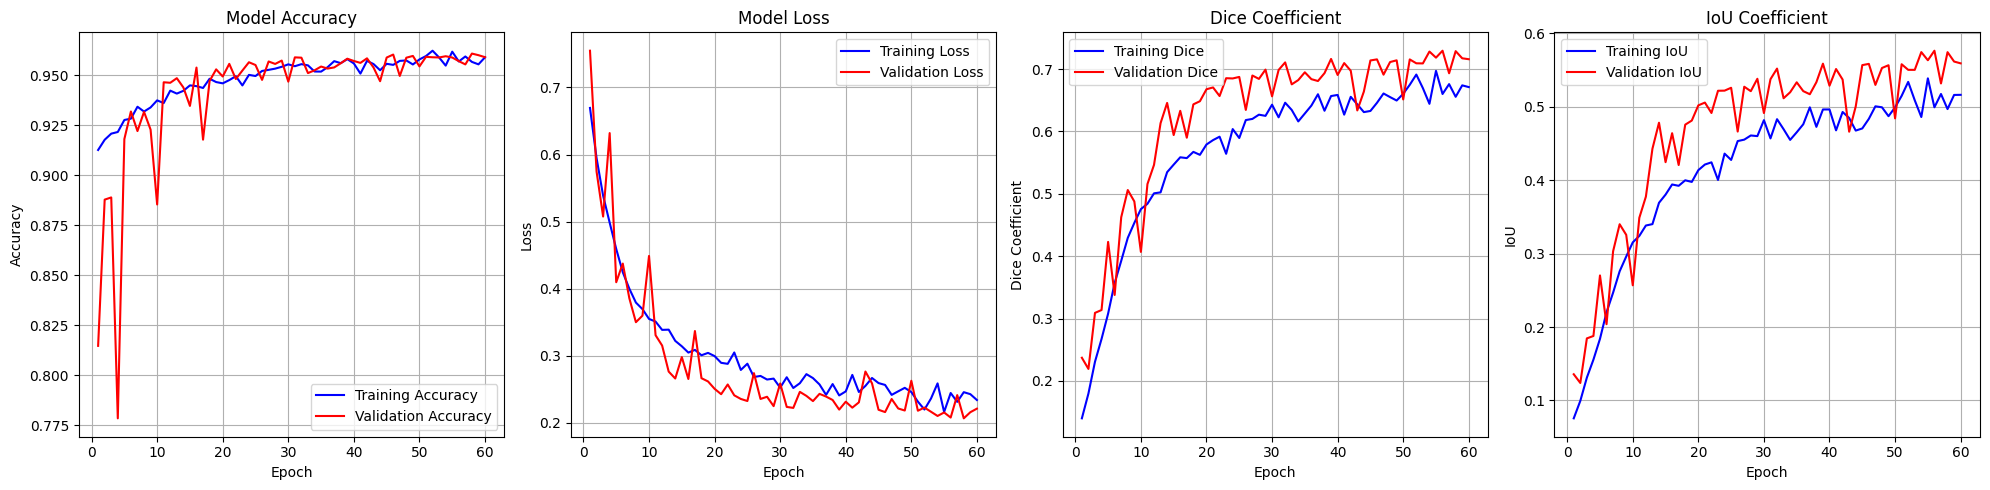


MODEL PERFORMANCE SUMMARY
Test Loss:     0.2296
Test Accuracy: 0.9541
Test Dice:     0.6871
Test IoU:      0.5251



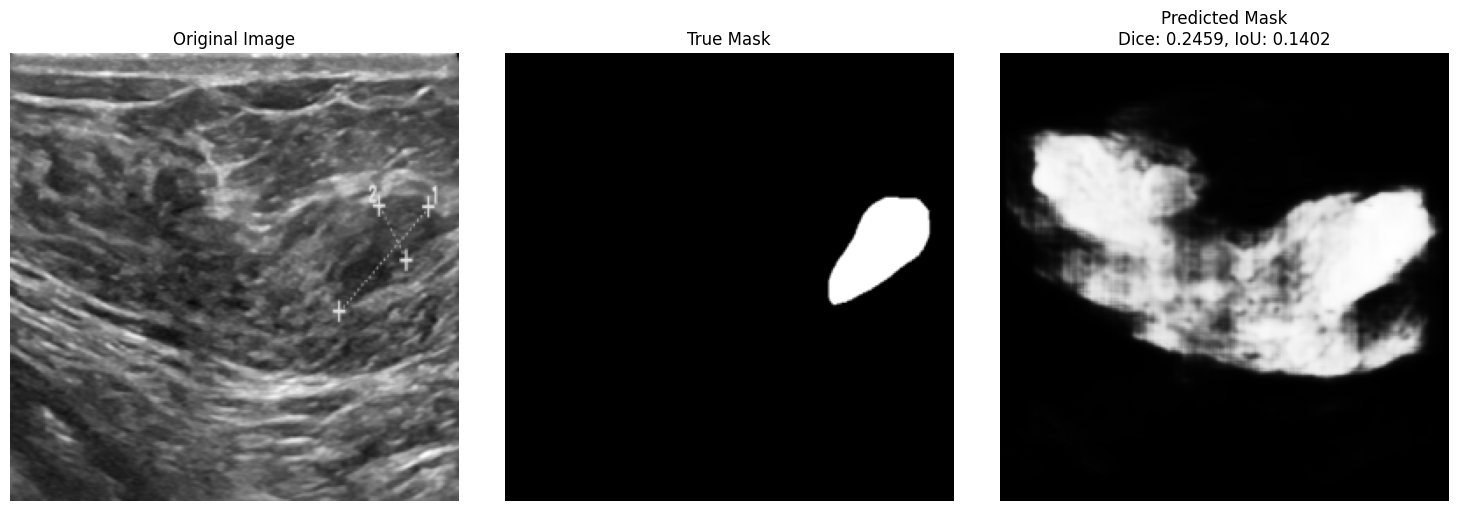

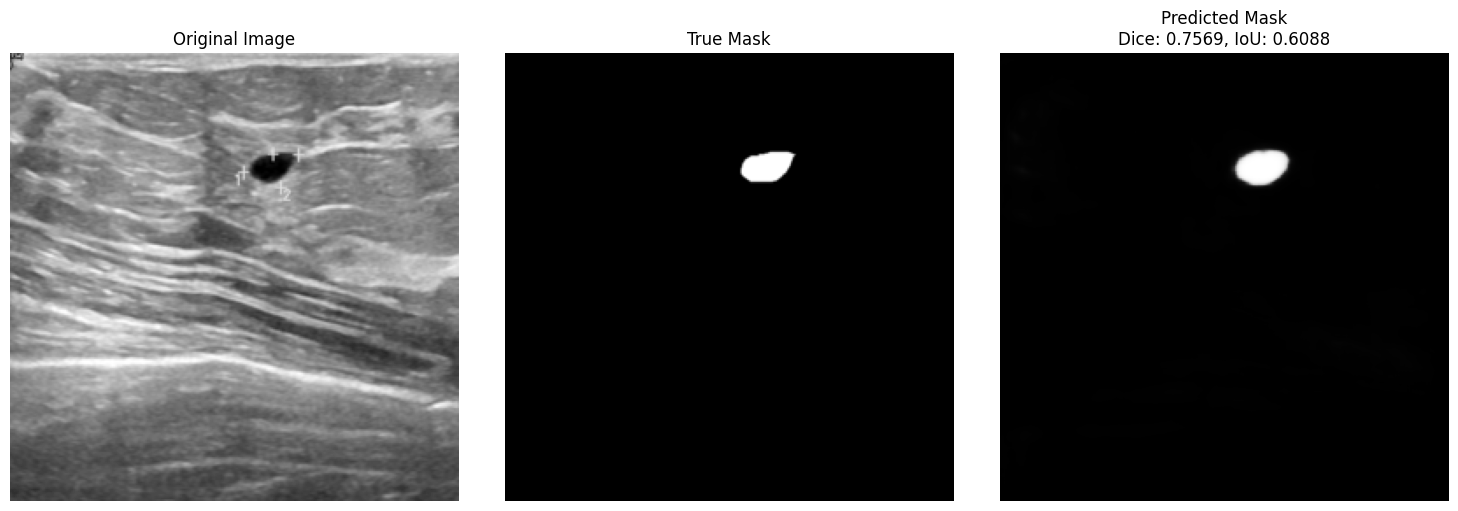

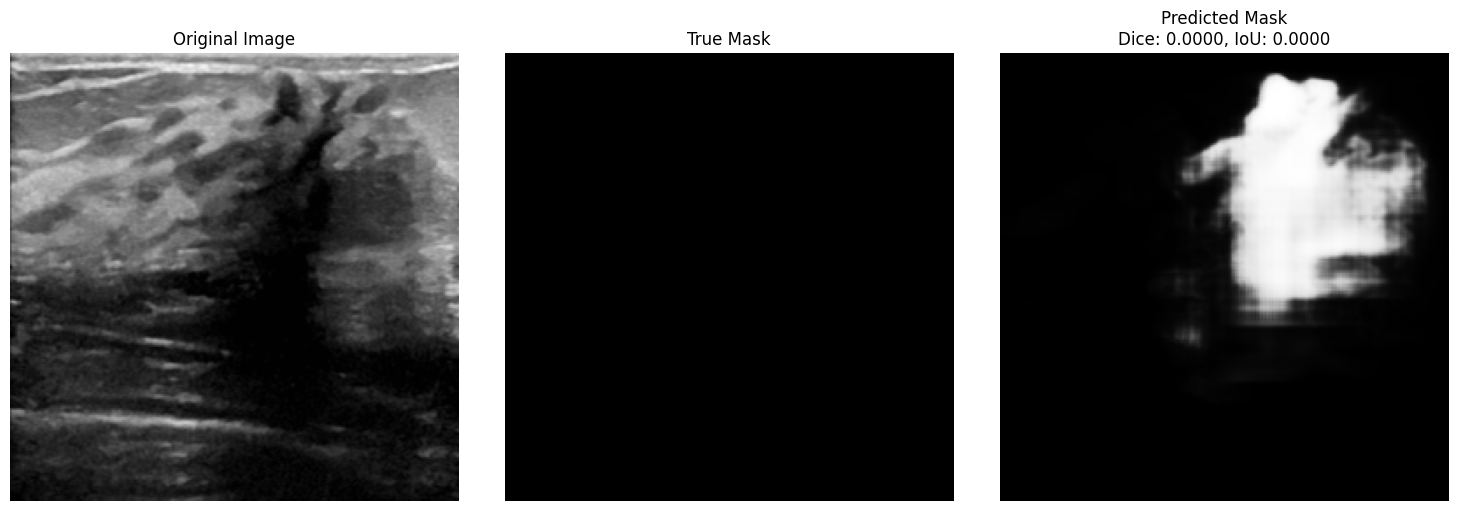

In [ ]:
def main():
    # Model Initialization
    model = UNet(in_channels=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
    # Load and prepare data
    data_path = ['Dataset_BUSI_with_GT/normal', 'Dataset_BUSI_with_GT/benign', 'Dataset_BUSI_with_GT/malignant']
    images, masks, classes = load_segmentation_data(data_path, data_path)
    
    # Create data loaders with augmentation
    train_loader, val_loader, test_loader = get_data_loaders(
        images=images,
        masks=masks,
        classes=classes,
        batch_size=BATCH_SIZE
    )
    
    # Initialize trainer
    trainer = Trainer(model, NUM_EPOCHS, optimizer, device)
    
    # Train model
    trainer.train(train_loader, val_loader)
    
    # Plot training history
    plot_training_history(trainer)
        
    # Load best model
    model.load_state_dict(torch.load(trainer.best_model_path))
    
    # Calculate and evaluate model summary
    evaluate_model(model, test_loader, device)
    
    # Plot some predictions
    plot_prediction_results(model, test_loader, device)

if __name__ == "__main__":
    main()